## Lib

In [1]:
import copy
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.metrics.pairwise import linear_kernel
from sklearn.feature_extraction.text import TfidfVectorizer

---
## I. Exploring the data

In [2]:
df = pd.read_csv('ML-technicaltest-ecommerce.csv')

In [3]:
df.head(5)

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom


In [4]:
num_rows, num_cols = df.shape
print("Dữ liệu có {} dòng, {} cột.".format(num_rows, num_cols))

Dữ liệu có 541909 dòng, 7 cột.


- InvoiceNo : Mã hóa đơn
- StockCode : Mã Sản phẩm
- Description : Mô tả các mặt hàng Sản phẩm
- Quantity : Số lượng các mặt hàng trong hóa đơn
- UnitPrice : Đơn giá của các mặt hàng trong hóa đơn
- CustomerID : ID khách hàng của hóa đơn
- Country : Quốc gia của khách hàng

In [5]:
#xem thông tin data:
df.info()
if df.isnull().values.any() == False:
    print("\n=> Không có ô giá trị nào bị thiếu.")
else:
    print("\n=> Dữ liệu bị thiếu.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   UnitPrice    541909 non-null  float64
 5   CustomerID   406829 non-null  float64
 6   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB

=> Dữ liệu bị thiếu.


Nhìn vào dữ liệu ta thấy dữ liệu thiếu ở cột 
+ Description có 1454 dòng null (chiếm 0.26% bộ dữ liệu)
+ CustomerID có 135080 dòng null (chiếm 24.92% bộ dữ liệu)

---

## II. Preprocessing

1. Chuẩn hóa dữ liệu chuổi

In [6]:
# Print all string into upper
df['StockCode'] = df['StockCode'].str.upper()
df['Description'] = df['Description'].str.upper()

# replace NaN with empty string
df['Description'] = df['Description'].fillna('')

2. Loại bỏ một số dòng không liên quan đến quá trình huấn luyện mô hình

In [7]:
new_df = df.copy()

# Drop row with UnitPride lower than 0
new_df = new_df[new_df.UnitPrice > 0]

# Drop row with Quantity lower than 0
new_df = new_df[new_df.Quantity > 0]

new_df =  new_df.drop_duplicates(subset=['StockCode'])

new_df = new_df.reset_index()
new_df = new_df.drop(columns = ['index', 'CustomerID', 'InvoiceNo', 'Quantity'])
new_df.head(5)

,StockCode,Description,UnitPrice,Country
0,85123A,WHITE HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
1,71053,WHITE METAL LANTERN,3.39,United Kingdom
2,84406B,CREAM CUPID HEARTS COAT HANGER,2.75,United Kingdom
3,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,3.39,United Kingdom
4,84029E,RED WOOLLY HOTTIE WHITE HEART.,3.39,United Kingdom


---
## III. Visualize

#### 1. Các Codestock xuất hiện nhiều nhất

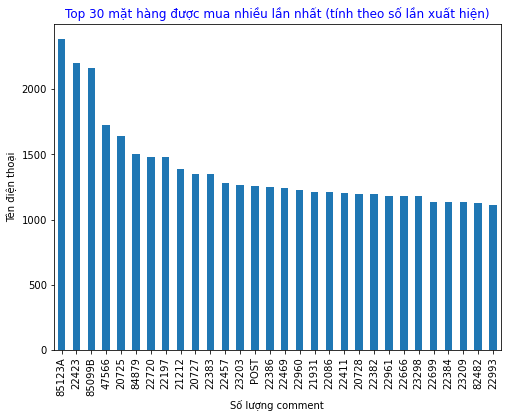

In [8]:
totalCommentCount = df.StockCode.value_counts()
lessComment = totalCommentCount[::].head(30)
plt.figure(figsize=(8, 6))
plt.xlabel("Số lượng comment")
plt.ylabel("Tên điện thoại")
plt.title('Top 30 mặt hàng được mua nhiều lần nhất (tính theo số lần xuất hiện)'
          ,color = 'blue')
lessComment.plot.bar()
plt.show()

#### 2. Tổng quan số lần xuất hiện của các sản phẩm

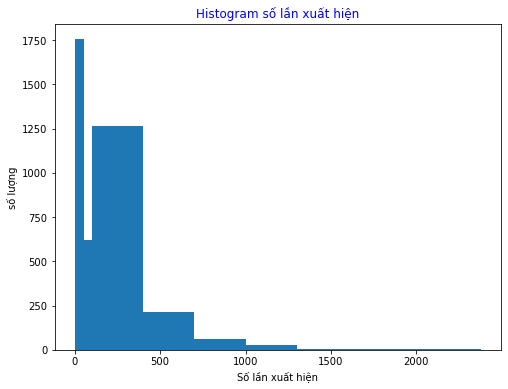

In [9]:
totalCommentCount = df.StockCode.value_counts()

plt.figure(figsize=(8, 6))
plt.ylabel("số lượng")
plt.xlabel("Số lần xuất hiện")
plt.title('Histogram số lần xuất hiện', color = 'blue')

sizes = totalCommentCount.values
plt.hist(sizes, bins = [0, 50, 100, 400, 700, 1000, 1300, 1600, sizes.max()])
plt.show()

---
## III. Train

##### 1. What is the raw input of the model?
    - Raw input của model là Description của các sản phẩm 
##### 2. Preprocessing and any feature engineering steps
    + Loại bỏ các dòng có UnitPrice <= 0
    + Loại bỏ các dòng có Quantity <= 0
    + Đưa các dòng Description có giá trị NULL về chuổi rỗng ""
    + Loại bỏ các dòng lặp lại (kết quả: mỗi sản phẩm chỉ xuất hiện trên một dòng)
##### 3. What are inputs/outputs in predicting?
    - input: a StockCode
    - output: top 5 stockCode tương tự với input
##### 4. ML Algorithms you choose, and why?
    - Mô hình được sữ dụng: content-based recommender system
    - Mô tả: dựa trên Description của sản phẩm tìm điểm chung của các sản phẩm với nhau, sau đó recommend cho người dùng.

In [10]:
# init, drop all stop word ('the', 'a', ...)
tfidf = TfidfVectorizer(stop_words='english')

# create tf-idf matrix
tfidf_matrix = tfidf.fit_transform(new_df['Description'])

tfidf_matrix.shape

(3812, 2055)

In [11]:
tfidf_matrix

<3812x2055 sparse matrix of type '<class 'numpy.float64'>'
	with 15688 stored elements in Compressed Sparse Row format>

In [12]:
#compute the cosine similarity matrix
cosine_similarity = linear_kernel(tfidf_matrix, tfidf_matrix)

# a reverse map of indices and  
indices = pd.Series(new_df.index, index = new_df['StockCode']).drop_duplicates()

In [13]:
def get_recommend(codeStock, cosine_sim = cosine_similarity):
    # get index in matrix
    idx = indices[codeStock]
    
    # get similary score series of idx
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    #sort top down
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse = True)
    
    #Pick top 5 product have highest similary score
    sim_scores = sim_scores[1:6]
    
    #get infomation of top  5
    stock_indices = [i[0] for i in sim_scores]
    
    return new_df.iloc[stock_indices]

---
## IV. Predict

In [14]:
print(new_df.StockCode.unique()[0:50])

['85123A' '71053' '84406B' '84029G' '84029E' '22752' '21730' '22633'
 '22632' '84879' '22745' '22748' '22749' '22310' '84969' '22623' '22622'
 '21754' '21755' '21777' '48187' '22960' '22913' '22912' '22914' '21756'
 '22728' '22727' '22726' '21724' '21883' '10002' '21791' '21035' '22326'
 '22629' '22659' '22631' '22661' '21731' '22900' '21913' '22540' '22544'
 '22492' 'POST' '22086' '20679' '37370' '21871']


In [15]:
stock = '85123A'
print('Sản phẩm input: \n' ,new_df[new_df.StockCode == stock])
print("\n--------------------------------------------------------------------")
print('\nSản phẩm output:')
get_recommend(stock)

Sản phẩm input: 
   StockCode                         Description  UnitPrice         Country
0    85123A  WHITE HANGING HEART T-LIGHT HOLDER       2.55  United Kingdom

--------------------------------------------------------------------

Sản phẩm output:


,StockCode,Description,UnitPrice,Country
58,21733,RED HANGING HEART T-LIGHT HOLDER,2.55,United Kingdom
166,84970S,HANGING HEART ZINC T-LIGHT HOLDER,0.64,United Kingdom
500,21814,HEART T-LIGHT HOLDER,1.45,United Kingdom
2291,85118,HEART T-LIGHT HOLDER,1.25,United Kingdom
1869,84978,HANGING HEART JAR T-LIGHT HOLDER,1.25,United Kingdom
